In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import requests
from tqdm import tqdm


def download_if_missing(url: str, dest: Path | str, chunk_size: int = 8192) -> Path:
    """
    Download *url* to *dest* unless the file is already present.

    Parameters
    ----------
    url : str
        HTTP or HTTPS address of the remote file.
    dest : pathlib.Path or str
        Target filename (absolute or relative).  Parent directories will be
        created automatically.
    chunk_size : int, optional
        Number of bytes to read per network iteration.  Defaults to 8 KiB.

    Returns
    -------
    pathlib.Path
        Path to the existing or newly downloaded file.

    Notes
    -----
    * Uses :pymeth:`pathlib.Path.exists` to avoid unnecessary downloads.  [oai_citation:4‡PyTutorial](https://pytutorial.com/check-file-existence-with-python-pathlibexists/?utm_source=chatgpt.com)
    * Streams the response with ``requests.get(..., stream=True)`` to handle
      large weights efficiently.  [oai_citation:5‡Real Python](https://realpython.com/python-download-file-from-url/?utm_source=chatgpt.com)
    * Displays a live progress bar powered by *tqdm*.  [oai_citation:6‡proxiesapi.com](https://proxiesapi.com/articles/downloading-binary-files-with-python-requests?utm_source=chatgpt.com)

    Examples
    --------
    >>> from pathlib import Path
    >>> ckpt = download_if_missing(
    ...     "https://huggingface.co/epigen/cellwhisperer/resolve/main/cellwhisperer_clip_v1.ckpt",
    ...     Path("~/models/cellwhisperer_clip_v1.ckpt"))
    >>> ckpt
    PosixPath('/home/you/models/cellwhisperer_clip_v1.ckpt')
    """
    dest = Path(dest).expanduser().resolve()
    if dest.exists():
        return dest  # nothing to do

    dest.parent.mkdir(parents=True, exist_ok=True)

    with requests.get(url, stream=True, timeout=60) as r:
        r.raise_for_status()
        total = int(r.headers.get("Content-Length", 0))
        with (
            tqdm(total=total, unit="B", unit_scale=True, desc=dest.name) as bar,
            open(dest, "wb") as f,
        ):
            for chunk in r.iter_content(chunk_size):
                if chunk:  # filter out keep-alive chunks
                    f.write(chunk)
                    bar.update(len(chunk))

    return dest

In [3]:
CKPT = "/Users/mengerj/repos/adata_hf_datasets/notebooks/cellwhisperer_jointemb_v1.ckpt"
URL = "https://medical-epigenomics.org/papers/schaefer2024/data/models/cellwhisperer_clip_v1.ckpt"
download_if_missing(URL, CKPT)

PosixPath('/Users/mengerj/repos/adata_hf_datasets/notebooks/cellwhisperer_jointemb_v1.ckpt')

In [6]:
from cellwhisperer.utils.model_io import load_cellwhisperer_model

# ----------------- load model on GPU -------------------
# IMPORTANT: cache=False to avoid repeated GPU loading on Mac MPS
pl_model, tokenizer, transcriptome_processor = load_cellwhisperer_model(
    CKPT, eval=True, cache=False
)

ModuleNotFoundError: No module named 'wandb'

In [7]:
import anndata

adata_path = "HIHA_pp.h5ad"
adata = anndata.read_h5ad(adata_path)
adata.X = adata.layers["counts"]

In [8]:
# get mps device
import torch

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [9]:
from adata_hf_datasets import InitialEmbedder

# cw_model_path: directory or file passed to GeneformerModel.from_pretrained(...)
ie = InitialEmbedder(
    method="cw-geneformer",
    embedding_dim=512,
    cw_model_path="/Users/mengerj/repos/adata_hf_datasets/external/Geneformer_v1/geneformer-12L-30M",
    device=device,
    # Optional:
    # processor_kwargs={"nproc": 6, "emb_label": ["sample_name"]},
    # model_config={"emb_mode": "cell", "emb_layer": -1, "forward_batch_size": 16},
)

In [ ]:
ie.prepare(adata)  # loads processor and CW Geneformer model
X = ie.embed(
    adata=adata,
    obsm_key="X_cw_geneformer",
    batch_size=64,  # optional: overrides model config forward_batch_size
    chunk_size=512,  # forwarded to processor (tokenization)
    target_sum=10_000,  # forwarded to processor
)

: 

In [14]:
# write X to file
import pickle

with open("cw_gf_HIHA.pkl", "wb") as f:
    pickle.dump(X, f)

In [16]:
import anndata

adata_path = "HIHA_pp.h5ad"
adata = anndata.read_h5ad(adata_path)

In [17]:
import numpy as np

adata.obs["n_counts"] = adata.obs["total_counts"]
adata.obs["sample_index"] = np.arange(adata.n_obs)

In [18]:
from adata_hf_datasets import InitialEmbedder

# cw_model_path: directory or file passed to GeneformerModel.from_pretrained(...)
ie = InitialEmbedder(
    method="geneformer-v1",
    geneformer_v1_root="/Users/mengerj/repos/adata_hf_datasets/external/Geneformer_v1",
)

In [19]:
ie.prepare(adata)
X = ie.embed(adata=adata, obsm_key="X_geneformer-v1")

ModuleNotFoundError: No module named 'transformers.modeling_layers'

In [10]:
import anndata as ad

adata = ad.read_zarr(
    "../data/RNA/processed_with_emb/train/cellxgene_pseudo_bulk_10k/train/chunk_0.zarr"
)

Neighbors computed from: X_cw-geneformer
Embedding shape: (8113, 512)


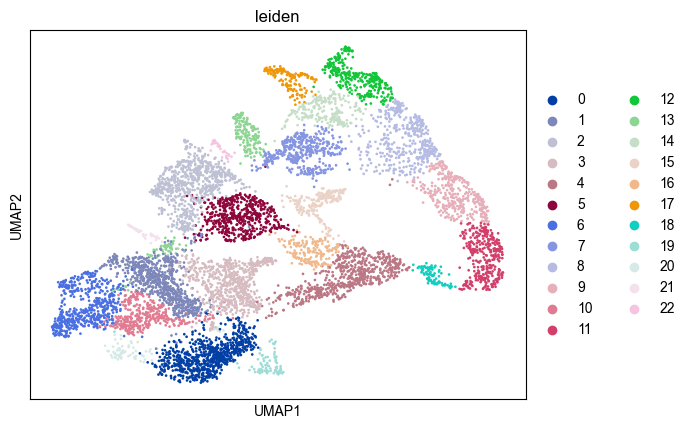

In [15]:
import scanpy as sc

# visualise the embedding using umap
key_to_plot = "X_cw-geneformer"
# perform leiden clustering
# del adata.uns["neighbors"]
# Clean up any old leiden color palettes
if "leiden_colors" in adata.uns:
    del adata.uns["leiden_colors"]
# Compute neighbors graph using the specified embedding with cosine distance
sc.pp.neighbors(adata, use_rep=key_to_plot, metric="cosine")
# Verify which representation was used (stored in neighbors params)
print(f"Neighbors computed from: {adata.uns['neighbors']['params']['use_rep']}")
print(f"Embedding shape: {adata.obsm[key_to_plot].shape}")
sc.tl.leiden(adata)
# Compute UMAP for visualization (uses the neighbors graph computed above)
umap_key = f"X_umap_{key_to_plot}"  # Store with explicit key
sc.tl.umap(adata, neighbors_key="neighbors")
sc.pl.umap(adata, color=["leiden"])